In [40]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [41]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [42]:
notes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Notes:', notes)

Notes: ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']


In [43]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 30828
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\en027a_55.wav', shape=(), dtype=string)


In [44]:
# Для удобства разбиения выборки на тренировочную, тестовую и валидационную возьмем только 28000 файлов, 
# которые разобьем в соотношении 70:20:10 

filenames = filenames[:28000]

train_files = filenames[:19600]
val_files = filenames[19600: 19600 + 5600]
test_files = filenames[-2800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 19600
Validation set size 5600
Test set size 2800


In [45]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11506, 1])

In [46]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def without_zero_len(waveform, label):
    if len(waveform)!=0:  
        return True
    return False

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
count = 0
for a,_ in waveform_ds:
    count+=1
    if a.shape[0]==0:
        print(count, filenames[count])
waveform_ds = waveform_ds.filter(without_zero_len) # Удаляем сигналы нулевой длины

1171 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en045a_5.wav', shape=(), dtype=string)
2199 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en022b_76.wav', shape=(), dtype=string)
4355 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en049a_84.wav', shape=(), dtype=string)
4425 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\E\\kr021b_42.wav', shape=(), dtype=string)
8201 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\kr002b_204.wav', shape=(), dtype=string)
9690 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\kr038b_134.wav', shape=(), dtype=string)
12707 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D\\kr019a_8.wav', shape=(), dtype=string)
14965 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en012b_80.wav', shape=(), dtype=string)
17485 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\C#\\kr005b_65.wav', shape=(), dtype=string)
19349 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en031a_54.wav', shape=(), dtype=string)


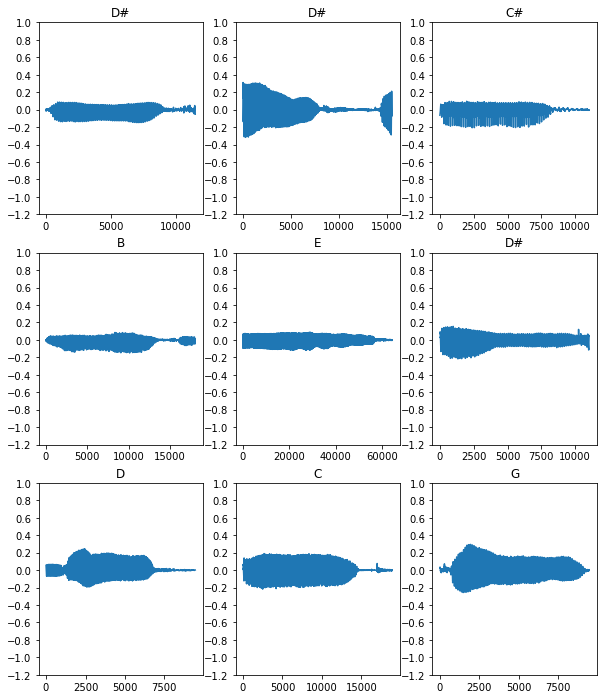

In [48]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [49]:
# Загружаем триангулярные фильтры
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(1025, 40)


In [50]:
def get_spectrogram(waveform):
    NFFT = 2048
    input_len = 1025*15
    waveform = waveform[:input_len]
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=2048, frame_step=1024,pad_end=True)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров

    return spectrogram

In [51]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)


print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Label: D#
Waveform shape: (11506,)
Spectrogram shape: (12, 40)
Audio playback


C:\Users\belas\AppData\Local\Temp/ipykernel_15328/3000733472.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


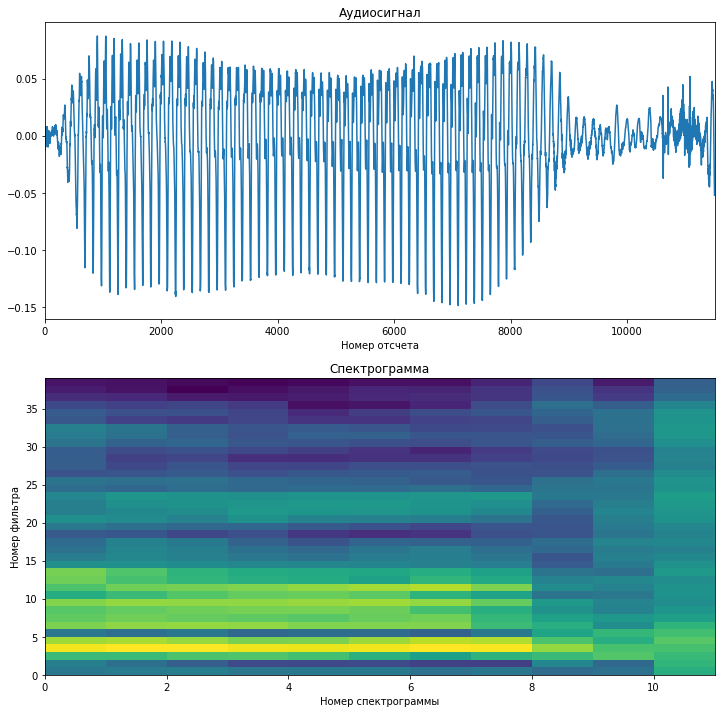

In [52]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[1]
    width = spectrogram.shape[0]
    #X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    X = np.array(range(width))
    Y = np.array(range(height))
    ax.pcolormesh(X, Y, spectrogram.T)

  
fig, axes = plt.subplots(2, figsize=(12, 12))
timescale = np.arange(waveform.shape[0])
axes[0].set_xlabel('Номер отсчета')
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Аудиосигнал')
axes[0].set_xlim([0, waveform.shape[0]])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Спектрограмма')
axes[1].set_xlabel('Номер спектрограммы')
axes[1].set_ylabel('Номер фильтра')
plt.show()    

In [20]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_15(spectrogram, label_id):
    
    spec_length = len(spectrogram)
    if spec_length<15:
        for k in range(15-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>15:
        spectrogram = spectrogram[0:15]

    return spectrogram, label_id

In [21]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_15(x,y))

In [22]:
for a,b in spectrogram_ds.take(10):
    print(a.shape)

(15, 40)
(15, 40)
(15, 40)
(15, 40)
(15, 40)
(15, 40)
(15, 40)
(15, 40)
(15, 40)
(15, 40)


C:\Users\belas\AppData\Local\Temp/ipykernel_15328/163531595.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


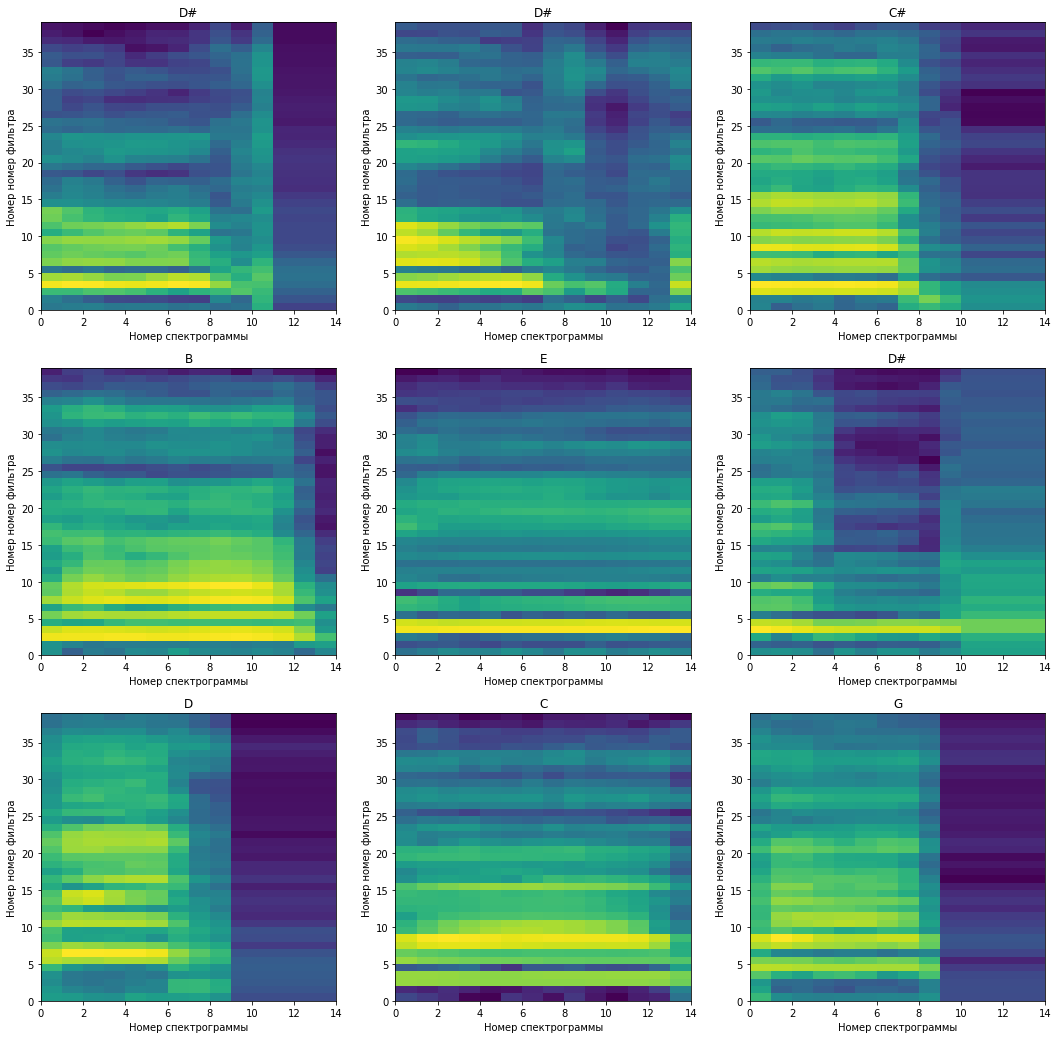

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_xlabel('Номер спектрограммы')
    axes[r][c].set_ylabel('Номер номер фильтра')


plt.show()

In [25]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.filter(without_zero_len) # Удаляем сигналы нулевой длины
    output_ds = output_ds.map(lambda x, y: get_spectrogram_and_label_id_15(x,y))
    return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
print('Фактические длины датасетов: ')
dataset_length = [i for i,_ in enumerate(train_ds)][-1] + 1
print('train_ds:', dataset_length)
dataset_length = [i for i,_ in enumerate(val_ds)][-1] + 1
print('val_ds:', dataset_length)
dataset_length = [i for i,_ in enumerate(test_ds)][-1] + 1
print('test_ds: ', dataset_length)

Фактические длины датасетов: 
train_ds: 19590
val_ds: 5595
test_ds:  2797


In [27]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [28]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [29]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

def create_model():
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512,activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512,activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512,activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    

model = create_model()
model.summary()

Input shape: (15, 40)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 15, 40)]          0         
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               307712    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 839,180
Trainable params:

In [30]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
307/307 [==============================] - 8s 26ms/step - loss: 1.5328 - accuracy: 0.5870 - val_loss: 0.9234 - val_accuracy: 0.6559
Epoch 2/100
307/307 [==============================] - 2s 6ms/step - loss: 0.6146 - accuracy: 0.7819 - val_loss: 0.7618 - val_accuracy: 0.7276
Epoch 3/100
307/307 [==============================] - 2s 6ms/step - loss: 0.5017 - accuracy: 0.8310 - val_loss: 0.4741 - val_accuracy: 0.8374
Epoch 4/100
307/307 [==============================] - 2s 6ms/step - loss: 0.4580 - accuracy: 0.8421 - val_loss: 0.4945 - val_accuracy: 0.8198
Epoch 5/100
307/307 [==============================] - 2s 6ms/step - loss: 0.4275 - accuracy: 0.8542 - val_loss: 0.4454 - val_accuracy: 0.8486
Epoch 6/100
307/307 [==============================] - 2s 6ms/step - loss: 0.4136 - accuracy: 0.8592 - val_loss: 0.4813 - val_accuracy: 0.8349
Epoch 7/100
307/307 [==============================] - 2s 6ms/step - loss: 0.3888 - accuracy: 0.8689 - val_loss: 0.5217 - val_accuracy: 0.814

Epoch 58/100
307/307 [==============================] - 2s 6ms/step - loss: 0.1474 - accuracy: 0.9495 - val_loss: 0.5833 - val_accuracy: 0.8624
Epoch 59/100
307/307 [==============================] - 2s 6ms/step - loss: 0.1606 - accuracy: 0.9437 - val_loss: 0.5245 - val_accuracy: 0.8769
Epoch 60/100
307/307 [==============================] - 2s 6ms/step - loss: 0.1490 - accuracy: 0.9486 - val_loss: 0.4891 - val_accuracy: 0.8833
Epoch 61/100
307/307 [==============================] - 2s 6ms/step - loss: 0.1348 - accuracy: 0.9524 - val_loss: 0.5303 - val_accuracy: 0.8847
Epoch 62/100
307/307 [==============================] - 2s 6ms/step - loss: 0.1359 - accuracy: 0.9511 - val_loss: 0.5440 - val_accuracy: 0.8792
Epoch 63/100
307/307 [==============================] - 2s 6ms/step - loss: 0.1381 - accuracy: 0.9516 - val_loss: 0.4814 - val_accuracy: 0.8937
Epoch 64/100
307/307 [==============================] - 2s 6ms/step - loss: 0.1528 - accuracy: 0.9478 - val_loss: 0.5160 - val_accuracy:

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

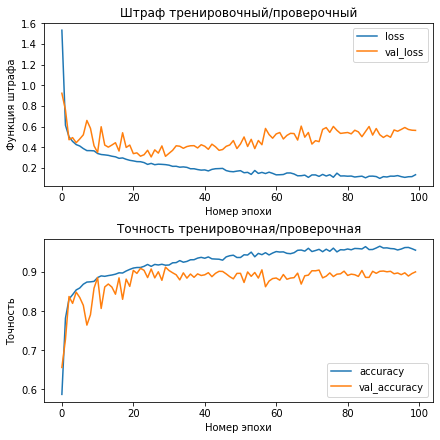

In [31]:
metrics = history.history

fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [32]:
test_audio = []
test_labels = []

count = 0
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [33]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true) * 100
print('Test set accuracy: ', test_acc, '%')

Test set accuracy:  91.8484090096532 %


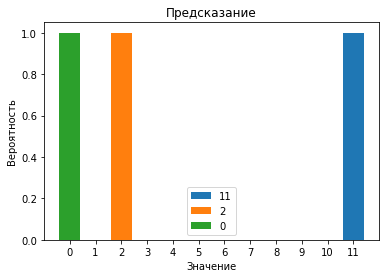

In [34]:
p = model.predict(test_audio)
for idx, pp in enumerate(p[:3]):
    plt.bar(np.arange(0,12),pp, label = y_true[idx])

plt.xlabel('Значение')
plt.ylabel('Вероятность')
plt.title('Предсказание')
plt.xticks(np.arange(0,12)) # ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']
plt.legend()

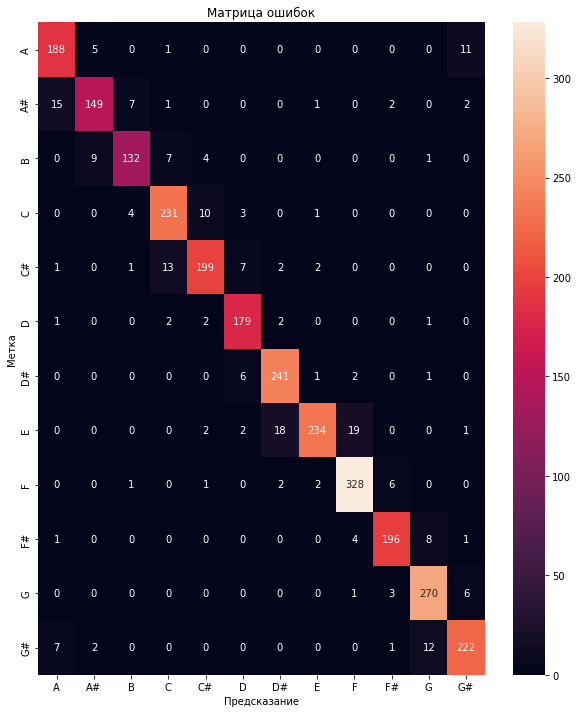

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

Sample file: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\en027a_55.wav', shape=(), dtype=string)


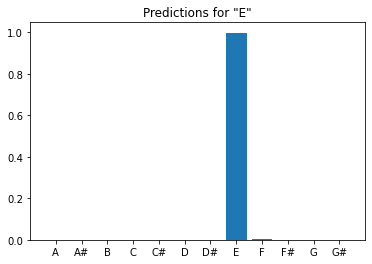

In [36]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', filenames[0])

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Predictions for "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()

In [37]:
# Сохраняем модель
model.save(r"D:\magistracy\diplom\model\new_model.h5")